In [1]:
import geopandas as gpd
import pandas as pd

import os
import requests
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import seaborn as sns

### get network (2018 & 2024) see 0_prepare_network_....ipynb

In [2]:
#osm_roads_all = gpd.read_file("osm_files/"+ shape_name_str+ "_roads_allYears.gpkg")

osm_roads_all = gpd.read_parquet("../processed_osm_files/germany_roads_2018_2024.parquet")

In [3]:
len(osm_roads_all)

2039082

In [4]:
## keep only roads with maxspeed 30 or 50
osm_roads_all=osm_roads_all[osm_roads_all.maxspeed.isin(["30","50"])].copy()

In [5]:
len(osm_roads_all)

978845

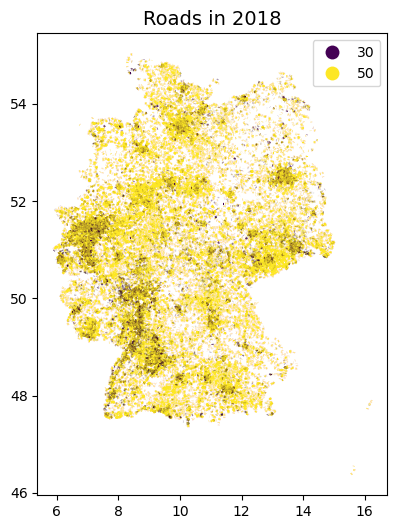

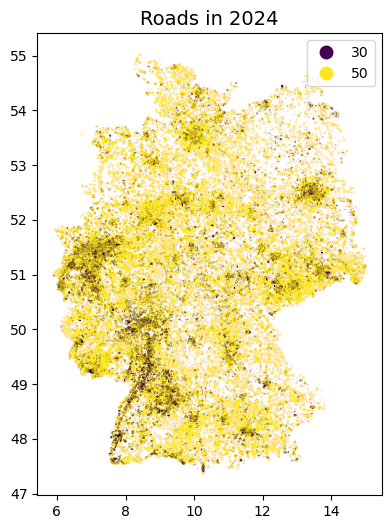

In [6]:
# plot the roads, takes some time (~1min per year/plot)
for y in osm_roads_all.year.unique():
    
    # Create a plot with color based on a column (e.g., 'road_type')
    ax = osm_roads_all[osm_roads_all.year == y].plot(
        column="maxspeed",  # Change this to the column you want for color
        cmap="viridis",  # Change color map if needed
        legend=True,  # Show color legend
        figsize=(10, 6)
    )
    
    # Add a title
    plt.title(f"Roads in {y}", fontsize=14)
    
    # Show plot
    plt.show()

## Excurse
### monitor length: abs and rel years and diffrent speeds

In [6]:
df_len=osm_roads_all.copy()

# Ensure the GeoDataFrame uses a projected CRS (for accurate length calculation)
if df_len.crs is None or df_len.crs.is_geographic:
    df_len = df_len.to_crs(epsg=25832)  # Convert to metric CRS (UTM for Germany)

# Compute the length of each line
df_len["length"] = df_len.geometry.length

# Group by year and maxspeed, then sum the lengths
length_summary = df_len.groupby(["year", "maxspeed"])["length"].sum().reset_index()

# Compute total length per year
total_length_per_year = df_len.groupby("year")["length"].sum().reset_index()
total_length_per_year["maxspeed"] = "Total"  # Mark it as total for merging later

# Merge total length data with the main summary
length_summary = pd.concat([length_summary, total_length_per_year], ignore_index=True)

# Convert length to kilometers for better readability
length_summary["length_km"] = length_summary["length"] / 1000

# Compute relative change for each maxspeed and total
length_summary["relative_change"] = length_summary.groupby("maxspeed")["length"].pct_change() * 100

In [7]:
length_summary

,year,maxspeed,length,length_km,relative_change
0,2018,30,4.545370e+06,4545.370284,NaN
1,2018,50,5.291211e+07,52912.112327,NaN
2,2024,30,6.453046e+06,6453.046487,41.969654
3,2024,50,6.247537e+07,62475.369337,18.073852
4,2018,Total,5.745748e+07,57457.482611,NaN
5,2024,Total,6.892842e+07,68928.415824,19.964211


### check out maxspeed:conditional
* todo: someday need to take maxspeed:conditional into account

In [8]:
osm_roads_all["maxspeed:conditional"].value_counts()

maxspeed:conditional
30 @ (22:00-06:00)                  4714
30 @ (Mo-Fr 07:00-17:00)            1515
30 @ (Mo-Fr 07:00-18:00)             677
30 @ (Mo-Fr 06:00-18:00)             557
30 @ (00:00-06:00,22:00-24:00)       435
                                    ... 
30 @ (07:00-16:30 AND Mo-Fr)           1
30 @ (mo-fr 06:00-17:00)               1
30 @ (2019 Feb 18-2019 Dec 22)         1
30 @ (Mo-Fr 06:00-08:00; PH off)       1
30 @ (Mo-Su 08:00-18:00)               1
Name: count, Length: 569, dtype: int64

In [9]:
df_len = osm_roads_all.copy()

# Ensure correct CRS for length calculation
if df_len.crs is None or df_len.crs.is_geographic:
    df_len = df_len.to_crs(epsg=25832)  # Convert to metric CRS (UTM for Germany)

# Compute length of each road segment
df_len["length"] = df_len.geometry.length

# **🚀 Step 1: Filter roads with maxspeed = 50 and conditional speed = 30 @ ...**
df_conditional_30 = df_len[
    (df_len["maxspeed"] == "50") & 
    (df_len["maxspeed:conditional"].notna()) & 
    (df_len["maxspeed:conditional"].str.startswith("30 @"))
].copy()

# **🚀 Step 2: Compute total length for roads with conditional maxspeed**
length_conditional_30 = df_conditional_30.groupby("year")["length"].sum().reset_index()
length_conditional_30.rename(columns={"length": "length_conditional_30"}, inplace=True)

# **🚀 Step 3: Compute total length for all maxspeed = 50 roads**
length_50 = df_len[df_len["maxspeed"] == "50"].groupby("year")["length"].sum().reset_index()
length_50.rename(columns={"length": "length_total_50"}, inplace=True)

# **🚀 Step 4: Merge both summaries together**
length_summary = length_50.merge(length_conditional_30, on="year", how="left").fillna(0)

# Convert to kilometers
length_summary["length_total_50_km"] = length_summary["length_total_50"] / 1000
length_summary["length_conditional_30_km"] = length_summary["length_conditional_30"] / 1000

# **🚀 Step 5: Compute percentage of roads affected by conditional speed limits**
length_summary["conditional_30_share"] = (length_summary["length_conditional_30"] / length_summary["length_total_50"]) * 100

# **🚀 Step 6: Compute relative change of conditional speed limits over years**
length_summary["relative_change_conditional_30"] = length_summary["length_conditional_30"].pct_change() * 100




In [10]:
length_summary

,year,length_total_50,length_conditional_30,length_total_50_km,length_conditional_30_km,conditional_30_share,relative_change_conditional_30
0,2018,5.291211e+07,3.459055e+05,52912.112327,345.905453,0.653736,NaN
1,2024,6.247537e+07,1.094280e+06,62475.369337,1094.280113,1.751538,216.352374


# read raster

<Axes: >

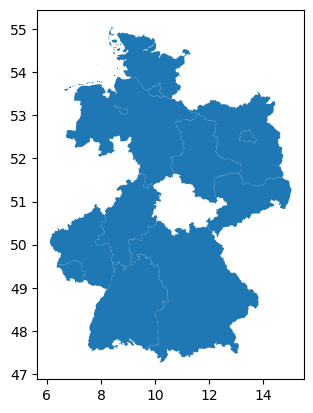

In [11]:
### to leave out MV, NRW and TH
bland = gpd.read_file("https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/main/2_bundeslaender/1_sehr_hoch.geo.json")
bland_fil=bland[~bland["id"].isin(["DE-MV","DE-NW","DE-TH"])]
bland_fil.plot()

In [12]:
## Download the raster file (Zensus 2022 grid) from the provided link

def download_file(url, target_folder):
    # Parse the URL and extract the filename without query parameters
    parsed_url = urlparse(url)
    filename = os.path.basename(parsed_url.path)  # Extracts only the base filename

    # Ensure the target folder is an absolute path
    if not os.path.isabs(target_folder):
        target_folder = os.path.abspath(target_folder)

    # Create the target directory if it does not exist
    os.makedirs(target_folder, exist_ok=True)

    # Define the full file path
    file_path = os.path.join(target_folder, filename)

    # Check if the file already exists
    if os.path.exists(file_path):
        print(f"File '{filename}' already exists in '{target_folder}'.")
        return file_path

    # Download the file
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an error for HTTP errors
        with open(file_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        print(f"File '{filename}' has been downloaded and saved in '{target_folder}'.")
        return file_path
    except requests.exceptions.RequestException as e:
        print(f"An error occurred while downloading the file: {e}")
        return None

# Example usage
download_link_raster = "https://stg-arcgisazurecdataprod2.az.arcgis.com/exportfiles-23163-15644/Zensus2022_grid_final_7053549391879339012.gpkg?sv=2018-03-28&sr=b&sig=xqi40fbZpXQvvkVSl9%2FyFqVQyEAEhvbRGXyUXpc1cts%3D&se=2025-03-18T16%3A20%3A38Z&sp=r"
target_folder = r'../raster_data'  # Ensure this is a valid absolute path
download_file(download_link_raster, target_folder)


File 'Zensus2022_grid_final_7053549391879339012.gpkg' already exists in 'c:\Users\simon\Nextcloud3\Analysen\osm_history_analysis\raster_data'.


'c:\\Users\\simon\\Nextcloud3\\Analysen\\osm_history_analysis\\raster_data\\Zensus2022_grid_final_7053549391879339012.gpkg'

In [13]:
## read downloaded raster file (with given mask)

def find_and_read_gpkg(directory, mask=None):
    # Ensure the directory exists
    if not os.path.exists(directory):
        print(f"Directory '{directory}' does not exist.")
        return None

    # List all .gpkg files in the directory
    gpkg_files = [f for f in os.listdir(directory) if f.endswith(".gpkg")]

    if not gpkg_files:
        print("No .gpkg files found in the directory.")
        return None

    # Select the first .gpkg file (or modify this to choose a specific one)
    gpkg_file = os.path.join(directory, gpkg_files[0])
    print(f"Reading: {gpkg_file}")

    # Load the .gpkg file into a GeoDataFrame
    try:
        gdf = gpd.read_file(gpkg_file, mask=mask)
        return gdf
    except Exception as e:
        print(f"Error reading {gpkg_file}: {e}")
        return None

# Example usage
target_folder = r'../raster_data'  # Ensure this is the correct folder path
raster_gdf = find_and_read_gpkg(target_folder, mask=bland_fil.to_crs(3857))



# Dieses Werk ist lizensiert unter der Datenlizenz Deutschland - Namensnennung - Version 2.0 
# © Statistische Ämter des Bundes und der Länder, 2024
# Gittergeometrien: © GeoBasis-DE / BKG (2024)


Reading: ../raster_data\Zensus2022_grid_final_7053549391879339012.gpkg


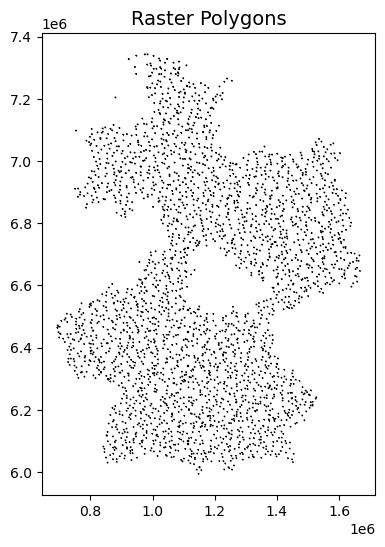

In [14]:

# Plot raster polygons with black edges
ax = raster_gdf[::100].plot(
    edgecolor="black",  # Set polygon borders to black
    facecolor="lightgray",  # Set fill color (adjust as needed)
    linewidth=1,  # Set border thickness
    figsize=(10, 6)  # Adjust figure size
)

# Add a title
plt.title("Raster Polygons", fontsize=14)

# Show plot
plt.show()

In [15]:
raster_gdf

,id,GITTER_ID_1km,Einwohner,Durchschnittsalter,DurchschnHHGroesse,durchschnMieteQM,durchschnFlaechejeWohn,durchschnFlaechejeBew,Eigentuemerquote,Leerstandsquote,...,Insgesamt_Gebaeude,Vor1919,a1919bis1948,a1949bis1978,a1979bis1990,a1991bis2000,a2001bis2010,a2011bis2019,a2020undspaeter,geometry
0,1kmN2716E4146,CRS3035RES1000mN2716000E4146000,371.0,39.81,2.51,7.64,115.49,56.89,72.41,2.05,...,112.0,34.0,15.0,30.0,3.0,20.0,6.0,0.0,0.0,"MULTIPOLYGON (((854598.205 6029494.835, 856075..."
1,1kmN2716E4147,CRS3035RES1000mN2716000E4147000,107.0,34.87,2.89,7.46,119.07,57.45,73.91,13.04,...,29.0,3.0,3.0,3.0,3.0,8.0,12.0,0.0,0.0,"MULTIPOLYGON (((856075.052 6029541.264, 857551..."
2,1kmN2716E4148,CRS3035RES1000mN2716000E4148000,67.0,40.58,2.68,9.00,93.59,41.99,52.38,NaN,...,15.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((857551.913 6029587.427, 859028..."
3,1kmN2717E4144,CRS3035RES1000mN2717000E4144000,73.0,41.51,2.43,5.93,105.74,64.36,17.86,0.00,...,24.0,16.0,10.0,0.0,0.0,0.0,0.0,3.0,0.0,"MULTIPOLYGON (((851599.044 6030884.392, 853076..."
4,1kmN2717E4145,CRS3035RES1000mN2717000E4145000,85.0,47.64,1.85,8.69,93.48,54.68,41.30,NaN,...,17.0,0.0,9.0,3.0,0.0,0.0,7.0,3.0,0.0,"MULTIPOLYGON (((853076.118 6030931.369, 854553..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287779,1kmN3550E4220,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((937359.877 7370687.643, 939100..."
287780,1kmN3550E4221,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((939100.296 7370725.682, 940840..."
287781,1kmN3551E4218,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((933839.338 7372356.168, 935580..."
287782,1kmN3551E4219,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((935580.111 7372394.982, 937320..."


In [16]:
## clean up the raster a bit
raster_gdf=raster_gdf[["id","geometry"]].copy()


### clip the roads for each raster and calculate the length of the roads in each raster

In [17]:

# takes ~40s

# 🎯 **Define Parameters (Change These as Needed)**
years = ["2018", "2024"]  # ✅ Modify this list to include any years you want
speed_categories = ["30", "50"]  # ✅ Modify speed limits if needed
crs_target = 25832  # ✅ Define target CRS

# ✅ **Ensure CRS Consistency**
gdf_lines = osm_roads_all.to_crs(crs_target).copy()
gdf_polygons = raster_gdf.to_crs(crs_target).copy()

# ✅ **Reset Index for Timestamp Access**
gdf_lines = gdf_lines.reset_index()

# 🚀 **Step 1: Pre-Filter Polygons that Contain at Least One Line**
gdf_polygons_filtered = gdf_polygons.sjoin(gdf_lines, how="inner", predicate="intersects").drop_duplicates(subset=['id_left'])[['id_left', 'geometry']]

# 🚀 **Step 2: Filter Lines for Selected Years & Speeds**
gdf_lines_filtered = gdf_lines[gdf_lines["year"].isin(years) & gdf_lines["maxspeed"].isin(speed_categories)]

# 🚀 **Step 3: Clip All Lines to Polygons at Once**
gdf_clipped = gdf_lines_filtered.overlay(gdf_polygons_filtered, how="intersection")

# 🚀 **Step 4: Compute Lengths Efficiently**
gdf_clipped["length"] = gdf_clipped.geometry.length

# 🚀 **Step 5: Aggregate by Polygon, Year, and Speed**
agg_data = gdf_clipped.groupby(["id_left", "year", "maxspeed"])["length"].sum().reset_index()

# 🚀 **Step 6: Pivot Table to Create Year/Speed Columns**
agg_pivot = agg_data.pivot(index="id_left", columns=["year", "maxspeed"], values="length").fillna(0)

# ✅ **Convert MultiIndex to Strings for Easier Column Handling**
agg_pivot.columns = [f"{str(col[0])}_length_{str(col[1])}" for col in agg_pivot.columns]

# 🚀 **Step 7: Compute Total Length & Ratios for Each Year Dynamically**
for year in years:
    agg_pivot[f"{year}_total_length"] = sum(agg_pivot.get(f"{year}_length_{speed}", 0) for speed in speed_categories)
    agg_pivot[f"{year}_ratio"] = agg_pivot.get(f"{year}_length_30", 0) / agg_pivot[f"{year}_total_length"]

# 🚀 **Step 8: Merge Results Back**
gdf_polygons_res = gdf_polygons_filtered.merge(agg_pivot, left_on="id_left", right_index=True, how="left").fillna(0)
gdf_polygons_res



,id_left,geometry,2018_length_50,2024_length_50,2018_length_30,2024_length_30,2018_total_length,2018_ratio,2024_total_length,2024_ratio
2,1kmN2716E4148,"MULTIPOLYGON (((402420.418 5265262.97, 403419....",1400.210681,307.187571,0.0,0.000000,1400.210681,0.0,307.187571,0.000000
5,1kmN2717E4146,"MULTIPOLYGON (((400408.946 5266234.445, 401407...",35.782227,35.782227,0.0,0.000000,35.782227,0.0,35.782227,0.000000
6,1kmN2717E4147,"MULTIPOLYGON (((401407.993 5266248.813, 402407...",1124.756992,1124.360899,0.0,122.442347,1124.756992,0.0,1246.803246,0.098205
7,1kmN2717E4148,"MULTIPOLYGON (((402407.037 5266263.172, 403406...",1806.196837,1797.863554,0.0,0.000000,1806.196837,0.0,1797.863554,0.000000
8,1kmN2718E4144,"MULTIPOLYGON (((398397.449 5267205.888, 399396...",1051.781117,771.042011,0.0,280.477108,1051.781117,0.0,1051.519118,0.266735
...,...,...,...,...,...,...,...,...,...,...
287761,1kmN3545E4219,"MULTIPOLYGON (((462040.185 6094986.978, 463039...",0.000000,12.974646,0.0,0.000000,0.000000,0.0,12.974646,0.000000
287764,1kmN3546E4219,"MULTIPOLYGON (((462026.114 6095986.868, 463025...",698.983415,809.787965,0.0,0.000000,698.983415,0.0,809.787965,0.000000
287765,1kmN3546E4220,"MULTIPOLYGON (((463025.265 6096000.478, 464024...",1604.829909,1653.478405,0.0,0.000000,1604.829909,0.0,1653.478405,0.000000
287766,1kmN3546E4221,"MULTIPOLYGON (((464024.416 6096014.094, 465023...",0.000000,173.477759,0.0,0.000000,0.000000,0.0,173.477759,0.000000


### create some variables and filter

In [18]:
first_year = "2018"
last_year = "2024"


# add total length of both networks 
gdf_polygons_res["diff_total_length"] = gdf_polygons_res[f"{last_year}_total_length"]-gdf_polygons_res[f"{first_year}_total_length"]

# add total length of both networks (TODO this needs probably some rethinking!!)
gdf_polygons_res["diff_total_length_rel"]=gdf_polygons_res["diff_total_length"]/((gdf_polygons_res[f"{last_year}_total_length"]+gdf_polygons_res[f"{first_year}_total_length"])/2)

# add the ratio between both years
gdf_polygons_res["diff_ratio_tempo30"]=gdf_polygons_res[f"{last_year}_ratio"]-gdf_polygons_res[f"{first_year}_ratio"]



In [21]:
# # keep only if there is any 30km/h part in 2024
# # keep only if the length of the streets did not change more than 10% over the years (dont want to handle new/rearanged oneway streets for example)
# gdf_polygons_filtered=gdf_polygons_res[(gdf_polygons_res[f"{last_year}_length_30"]>0) & ((gdf_polygons_res["diff_total_length_rel"].abs()<0.1))].sort_values("diff_ratio_tempo30")

In [22]:
# keep only if there is any 30km/h part in 2024
gdf_polygons_filtered=gdf_polygons_res[(gdf_polygons_res[f"{last_year}_length_30"]>0)].sort_values("diff_ratio_tempo30")
len(gdf_polygons_filtered)

12706

In [23]:
# keep only if the length of the streets did not change more than 10% over the years (dont want to handle new/rearanged oneway streets for example)
gdf_polygons_filtered=gdf_polygons_filtered[(gdf_polygons_filtered["diff_total_length_rel"].abs()<0.1)].sort_values("diff_ratio_tempo30")
len(gdf_polygons_filtered)

7399

In [24]:
gdf_polygons_filtered

,id_left,geometry,2018_length_50,2024_length_50,2018_length_30,2024_length_30,2018_total_length,2018_ratio,2024_total_length,2024_ratio,diff_total_length,diff_total_length_rel,diff_ratio_tempo30
79145,1kmN2920E4186,"MULTIPOLYGON (((437654.505 5469785.405, 438653...",0.000000,328.788848,333.719777,3.172751,333.719777,1.000000,331.961600,0.009558,-1.758177,-0.005282,-0.990442
254243,1kmN3376E4317,"MULTIPOLYGON (((562346.606 5927388.163, 563346...",0.000000,405.627253,429.872263,21.858073,429.872263,1.000000,427.485327,0.051132,-2.386937,-0.005568,-0.948868
221843,1kmN3269E4561,"MULTIPOLYGON (((807843.097 5823857.464, 808843...",0.000000,345.792993,372.438696,24.254439,372.438696,1.000000,370.047431,0.065544,-2.391265,-0.006441,-0.934456
98107,1kmN2868E4278,"MULTIPOLYGON (((530283.821 5419055.151, 531283...",52.623281,770.512547,734.514330,12.275386,787.137611,0.933146,782.787934,0.015682,-4.349677,-0.005541,-0.917464
23526,1kmN2795E4339,"MULTIPOLYGON (((592191.727 5346862.002, 593190...",47.286727,974.807076,972.420970,44.923880,1019.707697,0.953627,1019.730956,0.044055,0.023259,0.000023,-0.909573
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283898,1kmN3466E4316,"MULTIPOLYGON (((560078.951 6017349.026, 561078...",564.835417,0.000000,0.000000,563.835367,564.835417,0.000000,563.835367,1.000000,-1.000050,-0.001772,1.000000
221443,1kmN3251E4551,"MULTIPOLYGON (((798086.82 5805706.868, 799087....",84.949303,0.000000,0.000000,84.947418,84.949303,0.000000,84.947418,1.000000,-0.001885,-0.000022,1.000000
80133,1kmN2932E4077,"MULTIPOLYGON (((328536.144 5480240.174, 329535...",296.890697,0.000000,0.000000,293.240802,296.890697,0.000000,293.240802,1.000000,-3.649896,-0.012370,1.000000
4449,1kmN2763E4171,"MULTIPOLYGON (((424770.75 5312596.19, 425769.8...",273.755348,0.000000,0.000000,278.852819,273.755348,0.000000,278.852819,1.000000,5.097470,0.018449,1.000000


In [19]:

# Define the output file path
output_folder = "../output"
output_file = os.path.join(output_folder, "raster_germany_net.gpkg")

# ✅ **Step 1: Ensure the Folder Exists**
os.makedirs(output_folder, exist_ok=True)

# ✅ **Step 2: Check if File Exists**
if os.path.exists(output_file):
    print(f"File '{output_file}' already exists. Overwriting...")
else:
    print(f"Creating new file: {output_file}")

# ✅ **Step 3: Save the GeoDataFrame**
try:
    gdf_polygons_filtered.to_file(output_file, driver="GPKG")
    print(f"Successfully saved: {output_file}")
except Exception as e:
    print(f"Error saving file: {e}")


File '../output\raster_germany_net.gpkg' already exists. Overwriting...
Successfully saved: ../output\raster_germany_net.gpkg


# Unfälle

In [25]:
#accidents = gpd.read_file(r"accident_data/accidents_germany_2017-2023_si.gpkg")  # parsing time ~15s
accidents = gpd.read_parquet(r"../accident_data/accidents_germany_2017-2023_si.parquet") # parsing time ~2s

In [26]:
accidents

,OBJECTID,ULAND,UREGBEZ,UKREIS,UGEMEINDE,UJAHR,UMONAT,USTUNDE,UWOCHENTAG,UKATEGORIE,...,IstPKW,IstFuss,IstKrad,IstSonstig,LICHT,USTRZUSTAND,IstGkfz,OID_,PLST,geometry
0,1.0,1,0,55,12,2017,1,5,6,2,...,1,0,0,0,2,2,NaN,NaN,NaN,POINT (10.60903 54.15315)
1,2.0,1,0,60,53,2017,1,6,6,3,...,0,1,0,1,2,1,NaN,NaN,NaN,POINT (10.2515 53.86555)
2,3.0,1,0,61,11,2017,1,18,6,3,...,1,0,0,0,2,1,NaN,NaN,NaN,POINT (9.34834 54.0629)
3,4.0,1,0,55,42,2017,1,12,7,3,...,1,0,0,0,0,0,NaN,NaN,NaN,POINT (10.77041 53.9693)
4,5.0,1,0,62,60,2017,1,8,6,3,...,1,0,0,0,0,1,NaN,NaN,NaN,POINT (10.23148 53.55668)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677822,NaN,16,0,51,0,2023,11,13,6,3,...,0,0,0,0,0,0,0.0,269044.0,2.0,POINT (11.11681 50.99175)
1677823,NaN,16,0,67,89,2023,11,9,3,2,...,0,0,1,0,0,1,0.0,269045.0,2.0,POINT (10.74922 50.90326)
1677824,NaN,16,0,66,42,2023,11,14,4,3,...,0,1,0,0,0,1,0.0,269046.0,2.0,POINT (10.39856 50.57154)
1677825,NaN,16,0,55,0,2023,11,10,5,3,...,0,0,0,0,0,1,0.0,269047.0,2.0,POINT (11.33058 50.98586)


In [27]:
# nur schwere Unfälle
#accidents=accidents[accidents["UKATEGORIE"]!=3]

In [28]:
# clean up the accidents a bit
accidents=accidents[["UJAHR","UKATEGORIE","geometry"]].copy()

### create 10m buffer for relevant roads, to be able to filter accidents later

In [29]:
## unforntually this takes pretty long ~3min

osm_roads_all_buffer=osm_roads_all.copy()
osm_roads_all_buffer=osm_roads_all_buffer.to_crs(25832)
osm_roads_all_buffer["geometry"]=osm_roads_all_buffer.buffer(10)


In [30]:
accidents_25832=accidents.to_crs(25832)

##  clipp accidents that are close to relavant roads

In [31]:
# Ensure both datasets have spatial indexes
accidents_25832.sindex
osm_roads_all_buffer.sindex

# Faster alternative using a spatial join (used to clip here)
accidents_clipped = gpd.sjoin(
    accidents_25832, osm_roads_all_buffer, how="inner", predicate="intersects"
).drop(columns=["index_right","year"])  # Remove unnecessary index column (year is from network)

accidents_clipped

,UJAHR,UKATEGORIE,geometry,highway,maxspeed,maxspeed:conditional,maxspeed:type,maxspeed:forward,maxspeed:backward,id
0,2017,2,POINT (605079.423 6001757.555),secondary,50,None,None,None,None,39577170
0,2017,2,POINT (605079.423 6001757.555),secondary,50,None,None,None,None,783038159
1,2017,3,POINT (582297.218 5969288.968),primary,50,None,None,None,None,1000199832
1,2017,3,POINT (582297.218 5969288.968),secondary,50,None,None,None,None,528525610
1,2017,3,POINT (582297.218 5969288.968),secondary,50,None,None,None,None,528525610
...,...,...,...,...,...,...,...,...,...,...
1677792,2023,3,POINT (643416.941 5648827.22),secondary,50,None,None,None,None,308715955
1677816,2023,3,POINT (637257.87 5633718.37),secondary,50,None,None,None,None,182547838
1677816,2023,3,POINT (637257.87 5633718.37),secondary,50,None,None,None,None,182547838
1677816,2023,3,POINT (637257.87 5633718.37),secondary,50,None,None,None,None,33437754


In [32]:
# as accident e.g. in crossings can be counted multiple times, we need to drop duplicates
accidents_clipped = accidents_clipped[~accidents_clipped.index.duplicated(keep='first')]

accidents_clipped=accidents_clipped[["UJAHR","UKATEGORIE","geometry"]]
accidents_clipped=accidents_clipped.to_crs(4326).copy()

### Unfälle pro Kachel pro Jahr

In [33]:
gdf_polygons=raster_gdf.copy()

# Ensure CRS is the same for both GeoDataFrames
gdf_points = accidents_clipped.to_crs(gdf_polygons.crs)

# Perform spatial join (each point is assigned to a polygon)
joined = gpd.sjoin(gdf_points, gdf_polygons, predicate="within")

# Count points per polygon per year
point_counts = joined.groupby(["index_right", "UJAHR"]).size().reset_index(name="count")

# Pivot the data to create separate columns for each year
point_counts_pivot = point_counts.pivot(index="index_right", columns="UJAHR", values="count").fillna(0)

# Rename columns to match the format: "2018_count"
point_counts_pivot.columns = [f"{int(year)}_count" for year in point_counts_pivot.columns]

# Merge the count data back into the polygons GeoDataFrame
gdf_polygons_merge = gdf_polygons.merge(point_counts_pivot, left_index=True, right_index=True, how="left")

# Fill NaN values with 0 (for polygons that have no points)
gdf_polygons_merge = gdf_polygons_merge.fillna(0)

gdf_polygons_merge.sort_values("2023_count",ascending=False).head()

,id,geometry,2017_count,2018_count,2019_count,2020_count,2021_count,2022_count,2023_count
254727,1kmN3382E4321,"MULTIPOLYGON (((1113194.908 7084581.169, 11148...",95.0,100.0,103.0,81.0,93.0,113.0,141.0
221882,1kmN3273E4552,"MULTIPOLYGON (((1492157.369 6894262.11, 149379...",0.0,140.0,126.0,78.0,104.0,126.0,129.0
202537,1kmN3251E4302,"MULTIPOLYGON (((1082142.921 6866966.497, 10837...",56.0,88.0,77.0,80.0,82.0,76.0,113.0
221795,1kmN3270E4551,"MULTIPOLYGON (((1490288.913 6889414.492, 14919...",0.0,134.0,134.0,133.0,119.0,115.0,107.0
221894,1kmN3272E4555,"MULTIPOLYGON (((1496994.079 6892388.295, 14986...",0.0,124.0,124.0,121.0,119.0,89.0,100.0


#### Check result for one Kachel

In [34]:
# Ensure CRS is the same for both GeoDataFrames
gdf_points = accidents_clipped.to_crs(gdf_polygons.crs)

joined_kachel = gpd.sjoin(gdf_points, gdf_polygons[gdf_polygons["id"]=="1kmN3382E4321"], predicate="within")
joined_kachel

,UJAHR,UKATEGORIE,geometry,index_right,id
7157,2017,3,POINT (1114264.731 7084972.498),254727,1kmN3382E4321
8200,2017,3,POINT (1113899.774 7084990.059),254727,1kmN3382E4321
8276,2017,3,POINT (1113780.001 7084960.099),254727,1kmN3382E4321
8359,2017,3,POINT (1114048.685 7085007.49),254727,1kmN3382E4321
8418,2017,3,POINT (1113258.058 7084945.192),254727,1kmN3382E4321
...,...,...,...,...,...
1567919,2023,2,POINT (1114136.109 7086027.622),254727,1kmN3382E4321
1567938,2023,3,POINT (1113967.801 7085024.552),254727,1kmN3382E4321
1567984,2023,3,POINT (1113948.293 7085739.003),254727,1kmN3382E4321
1568029,2023,3,POINT (1113911.721 7085189.62),254727,1kmN3382E4321


## definieren vorher / nachher für Unfälle
* ab 2018 gibts auch Berlin
* 2020 ist krass corona zeugs
* neusten daten sind von 2023

In [35]:
gdf_polygons_merge["vorher"]=gdf_polygons_merge["2018_count"]+gdf_polygons_merge["2019_count"]#+gdf_polygons_merge["2017_count"]
gdf_polygons_merge["nachher"]=gdf_polygons_merge["2023_count"]+gdf_polygons_merge["2022_count"]#+gdf_polygons_merge["2023_count"]

gdf_polygons_merge["unfall_ratio"]=(gdf_polygons_merge["nachher"]-gdf_polygons_merge["vorher"]) / gdf_polygons_merge["vorher"]

gdf_polygons_merge

,id,geometry,2017_count,2018_count,2019_count,2020_count,2021_count,2022_count,2023_count,vorher,nachher,unfall_ratio
0,1kmN2716E4146,"MULTIPOLYGON (((854598.205 6029494.835, 856075...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,1kmN2716E4147,"MULTIPOLYGON (((856075.052 6029541.264, 857551...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,1kmN2716E4148,"MULTIPOLYGON (((857551.913 6029587.427, 859028...",0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,1kmN2717E4144,"MULTIPOLYGON (((851599.044 6030884.392, 853076...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,1kmN2717E4145,"MULTIPOLYGON (((853076.118 6030931.369, 854553...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
287779,1kmN3550E4220,"MULTIPOLYGON (((937359.877 7370687.643, 939100...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
287780,1kmN3550E4221,"MULTIPOLYGON (((939100.296 7370725.682, 940840...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
287781,1kmN3551E4218,"MULTIPOLYGON (((933839.338 7372356.168, 935580...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
287782,1kmN3551E4219,"MULTIPOLYGON (((935580.111 7372394.982, 937320...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [36]:
relevant_accidents=gdf_polygons_merge.to_crs(4326).copy()
raster_germany_net=gdf_polygons_filtered.to_crs(4326).copy()

relevant_accidents=relevant_accidents.drop(columns=['geometry'])

### JOING rasters that have the net and the acc info

In [37]:
# fin_join=raster_germany_net[['id_left', '2018_length_50', '2024_length_50',
#        '2018_length_30', '2024_length_30', '2018_total_length', '2018_ratio',
#        '2024_total_length', '2024_ratio', 'diff_total_length',
#        'diff_total_length_rel', 'diff_ratio_tempo30']].merge(relevant_accidents, left_on="id_left", right_on="id").sort_values("diff_ratio_tempo30")

fin_join=raster_germany_net.merge(relevant_accidents, left_on="id_left", right_on="id").sort_values("diff_ratio_tempo30")

In [38]:
len(fin_join)

7399

In [36]:
### add bedigung für Länge der Straßen!!! mind 1000m?
#gdf_buffered_centroids=gdf_buffered_centroids[gdf_buffered_centroids[f"{last_year}_total_length"]>1000].copy()

In [41]:
fin_join_minroadlength=fin_join[fin_join[f"{last_year}_total_length"]>300]#.copy()
len(fin_join_minroadlength)

6358

In [42]:
fin_join_minroadlength_minacc=fin_join_minroadlength[fin_join_minroadlength.vorher>=3]#.copy()
len(fin_join_minroadlength_minacc)

2801

In [38]:
fin_join.head()

,id_left,geometry,2018_length_50,2024_length_50,2018_length_30,2024_length_30,2018_total_length,2018_ratio,2024_total_length,2024_ratio,...,2017_count,2018_count,2019_count,2020_count,2021_count,2022_count,2023_count,vorher,nachher,unfall_ratio
0,1kmN2920E4186,"MULTIPOLYGON (((8.1411 49.37758, 8.15486 49.37...",0.000000,328.788848,333.719777,3.172751,333.719777,1.000000,331.961600,0.009558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,1kmN3376E4317,"MULTIPOLYGON (((9.93974 53.49176, 9.95481 53.4...",0.000000,405.627253,429.872263,21.858073,429.872263,1.000000,427.485327,0.051132,...,0.0,0.0,1.0,2.0,2.0,0.0,0.0,1.0,0.0,-1.0
2,1kmN3269E4561,"MULTIPOLYGON (((13.53385 52.47785, 13.54855 52...",0.000000,345.792993,372.438696,24.254439,372.438696,1.000000,370.047431,0.065544,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-1.0
3,1kmN2868E4278,"MULTIPOLYGON (((9.41341 48.92369, 9.42705 48.9...",52.623281,770.512547,734.514330,12.275386,787.137611,0.933146,782.787934,0.015682,...,2.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
4,1kmN2795E4339,"MULTIPOLYGON (((10.24235 48.26825, 10.25582 48...",47.286727,974.807076,972.420970,44.923880,1019.707697,0.953627,1019.730956,0.044055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [40]:
#fin_join.to_file("../output/germany_raster2022_net_acc.gpkg")

output_path = "../output/germany_raster2022_net_acc.gpkg"

if not os.path.exists(output_path):
    print(f"File does not exist. Writing to {output_path}...")
    fin_join.to_file(output_path)
    print("File successfully written.")
else:
    print(f"File already exists at {output_path}. Skipping write.")

File already exists at ../output/germany_raster2022_net_acc.gpkg. Skipping write.


## deprecated

["unfall_ratio"]=(["nachher"]-["vorher"]) / ["vorher"] -> negative: Weniger unfälle | positiv mehr unfälle 

["diff_ratio_tempo30"]=["2024_ratio"]-["2016_ratio"] -> je größer desto besser wurde die infra

In [4]:
## if i skip the processing above, i can load the file here
path = "../output/germany_raster2022_net_acc.gpkg"

fin_join = gpd.read_file(path)


In [6]:
## set filter for plots

first_year = "2018"
last_year = "2024"

df = fin_join.copy()
df["unfall_ratio"]=df["unfall_ratio"]*100
df["diff_ratio_tempo30"]=df["diff_ratio_tempo30"]*100
df=df[df.vorher>=3].copy()
df=df[df[f"{last_year}_total_length"]>300].copy()

In [7]:
## find the dots for mirco viz
#df[(df["unfall_ratio"]>100) & (df["unfall_ratio"]<200)& (df["diff_ratio_tempo30"]>50) & (df["diff_ratio_tempo30"]<75)].sort_values("unfall_ratio",ascending=False).head(10)


## find the dots for mirco viz
df[(df["unfall_ratio"]>-50) & (df["unfall_ratio"]<-30)& (df["diff_ratio_tempo30"]>75) & (df["diff_ratio_tempo30"]<85)].sort_values("diff_ratio_tempo30",ascending=False).head(10)

,id_left,2018_length_50,2024_length_50,2018_length_30,2024_length_30,2018_total_length,2018_ratio,2024_total_length,2024_ratio,diff_total_length,...,2018_count,2019_count,2020_count,2021_count,2022_count,2023_count,vorher,nachher,unfall_ratio,geometry
7190,1kmN2951E4387,540.940984,0.000000,97.614219,638.256085,638.555203,0.152867,638.256085,1.000000,-0.299117,...,2.0,1.0,0.0,1.0,2.0,0.0,3.0,2.0,-33.333333,"MULTIPOLYGON (((10.91415 49.66801, 10.928 49.6..."
7171,1kmN3269E4554,4089.188018,655.105722,140.160376,3327.624226,4229.348393,0.033140,3982.729948,0.835513,-246.618445,...,60.0,79.0,44.0,47.0,47.0,45.0,139.0,92.0,-33.812950,"MULTIPOLYGON (((13.43092 52.48086, 13.44562 52..."
7150,1kmN2910E4213,1455.678049,347.219895,0.000000,1113.973201,1455.678049,0.000000,1461.193096,0.762372,5.515047,...,1.0,4.0,4.0,2.0,2.0,1.0,5.0,3.0,-40.000000,"MULTIPOLYGON (((8.51551 49.29319, 8.52925 49.2..."


## scatter plots

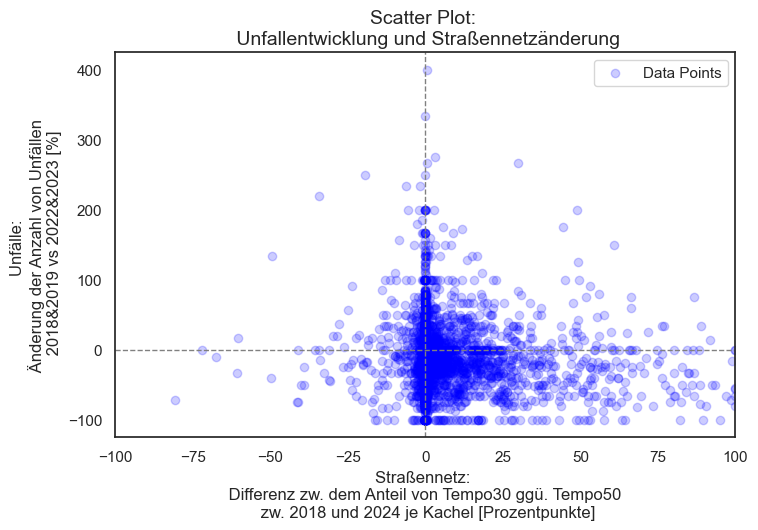

In [8]:
sns.set_theme(style='white')


# Scatter Plot
plt.figure(figsize=(8, 5))
plt.scatter(df["diff_ratio_tempo30"], df["unfall_ratio"], color='blue', alpha=0.2, label="Data Points")

# Add horizontal and vertical lines at 0
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)

# Set x-axis limits
plt.xlim(-100, 100)

# Labels
plt.xlabel("Straßennetz: \n Differenz zw. dem Anteil von Tempo30 ggü. Tempo50 \n zw. 2018 und 2024 je Kachel [Prozentpunkte]")  # Change X-axis title
plt.ylabel("Unfälle: \n Änderung der Anzahl von Unfällen \n 2018&2019 vs 2022&2023 [%]")  # Change Y-axis title
plt.title("Scatter Plot: \n Unfallentwicklung und Straßennetzänderung", fontsize=14)  # Change plot title
plt.legend()
plt.show()

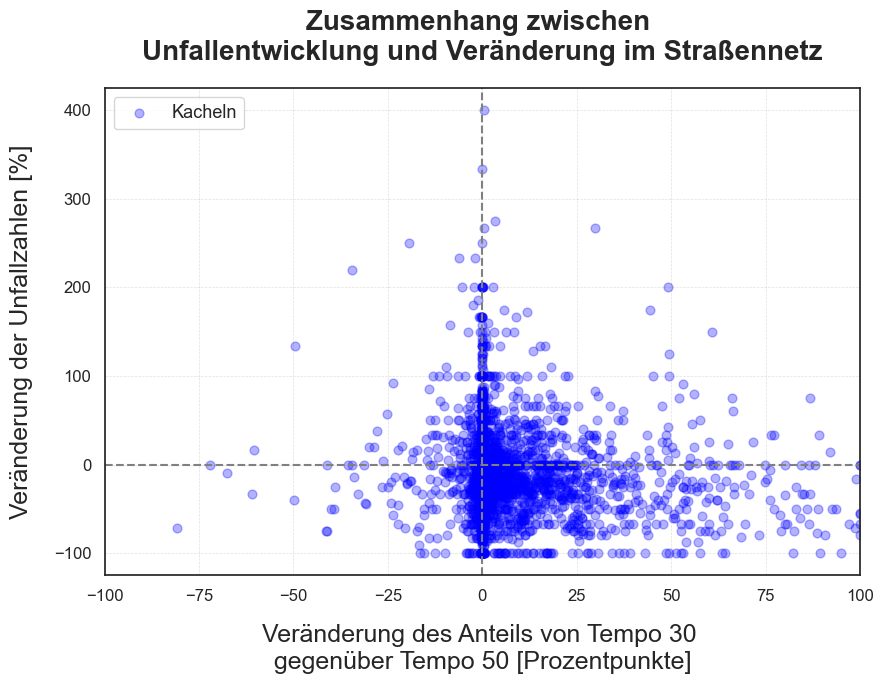

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='white')

# Create figure and adjust size for presentation
plt.figure(figsize=(9, 7))  # Bigger for slide visibility

# Scatter Plot
plt.scatter(
    df["diff_ratio_tempo30"],
    df["unfall_ratio"],
    color='blue',
    alpha=0.3,
    label="Kacheln",
    s=40  # Increase marker size
)

# Add reference lines
plt.axhline(0, color='gray', linestyle='--', linewidth=1.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=1.5)

# Axis limits
plt.xlim(-100, 100)

# Labels with increased font size
plt.xlabel(
    #"Veränderung des Anteils von Tempo 30 gegenüber Tempo 50\n(zwischen 2018 und 2024) [Prozentpunkte]",
    "Veränderung des Anteils von Tempo 30 \ngegenüber Tempo 50 [Prozentpunkte]",
    fontsize=18,
    labelpad=15
)
plt.ylabel(
    #"Veränderung der Unfallzahlen\n(2018/2019 vs. 2022/2023) [%]",
    "Veränderung der Unfallzahlen [%]",
    fontsize=18,
    labelpad=15
)

# Title
plt.title(
    "Zusammenhang zwischen \nUnfallentwicklung und Veränderung im Straßennetz",
    fontsize=20,
    weight='bold',
    pad=20
)

# Tick label size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Legend with larger font
plt.legend(fontsize=13, loc="upper left")

# Add grid for better readability (optional)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

# Tight layout for clean margins
plt.tight_layout()

# Save plot as high-resolution PNG before showing it
plt.savefig("../plots/scatterplot_tempo30_unfallanalyse.png", dpi=400, bbox_inches='tight')

# Then show the plot
plt.show()


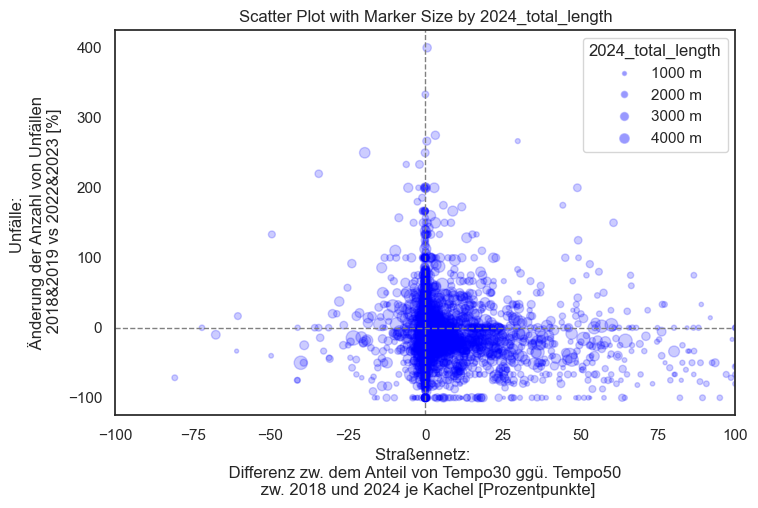

In [112]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

sns.set_theme(style='white')


# Normalize size for visibility
size_reference = df["2024_total_length"]
sizes = size_reference / size_reference.max() * 200  # Adjust scale as needed

# Scatter Plot
plt.figure(figsize=(8, 5))
scatter = plt.scatter(
    df["diff_ratio_tempo30"],
    df["unfall_ratio"],
    s=sizes,
    color='blue',
    alpha=0.2,
    label="Data Points"
)

# Add horizontal and vertical lines at 0
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)

# Set x-axis limits
plt.xlim(-100, 100)

# Labels
plt.xlabel("Straßennetz: \n Differenz zw. dem Anteil von Tempo30 ggü. Tempo50 \n zw. 2018 und 2024 je Kachel [Prozentpunkte]")  # Change X-axis title
plt.ylabel("Unfälle: \n Änderung der Anzahl von Unfällen \n 2018&2019 vs 2022&2023 [%]")  # Change Y-axis title
plt.title("Scatter Plot with Marker Size by 2024_total_length")

# Custom size legend
legend_sizes = [1000, 2000, 3000, 4000]  # example values in same units as 2024_total_length
legend_markers = [
    Line2D([0], [0], marker='o', color='w', label=f"{int(size)} m",
           markerfacecolor='blue', alpha=0.4,
           markersize=np.sqrt(size / size_reference.max() * 200))  # match scaling
    for size in legend_sizes
]

plt.legend(handles=legend_markers, title="2024_total_length", loc="upper right")

plt.show()



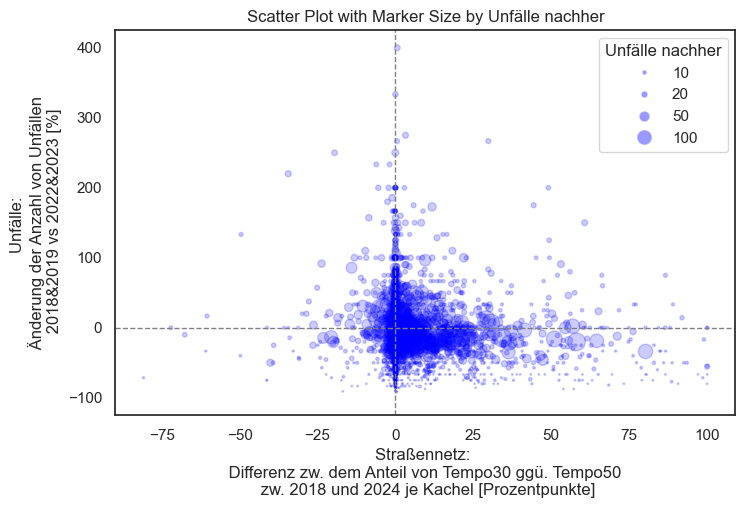

In [113]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

sns.set_theme(style='white')

# Normalize size for visibility
size_reference = df["nachher"]
sizes = size_reference / size_reference.max() * 300  # Adjust scale as needed

# Scatter Plot
plt.figure(figsize=(8, 5))
scatter = plt.scatter(
    df["diff_ratio_tempo30"],
    df["unfall_ratio"],
    s=sizes,
    color='blue',
    alpha=0.2,
    label="Data Points"
)

# Add horizontal and vertical lines at 0
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)

# Labels
#plt.xlabel("diff_ratio_tempo30")
#plt.ylabel("unfall_ratio")
# **Custom Axis Titles**
plt.xlabel("Straßennetz: \n Differenz zw. dem Anteil von Tempo30 ggü. Tempo50 \n zw. 2018 und 2024 je Kachel [Prozentpunkte]")  # Change X-axis title
plt.ylabel("Unfälle: \n Änderung der Anzahl von Unfällen \n 2018&2019 vs 2022&2023 [%]")  # Change Y-axis title
plt.title("Scatter Plot with Marker Size by Unfälle nachher")

# Custom size legend
legend_sizes = [10, 20, 50, 100]  # example values in same units as 2024_total_length
legend_markers = [
    Line2D([0], [0], marker='o', color='w', label=f"{int(size)}",
           markerfacecolor='blue', alpha=0.4,
           markersize=np.sqrt(size / size_reference.max() * 300))  # match scaling
    for size in legend_sizes
]

plt.legend(handles=legend_markers, title="Unfälle nachher", loc="upper right")

plt.show()

## boxplots

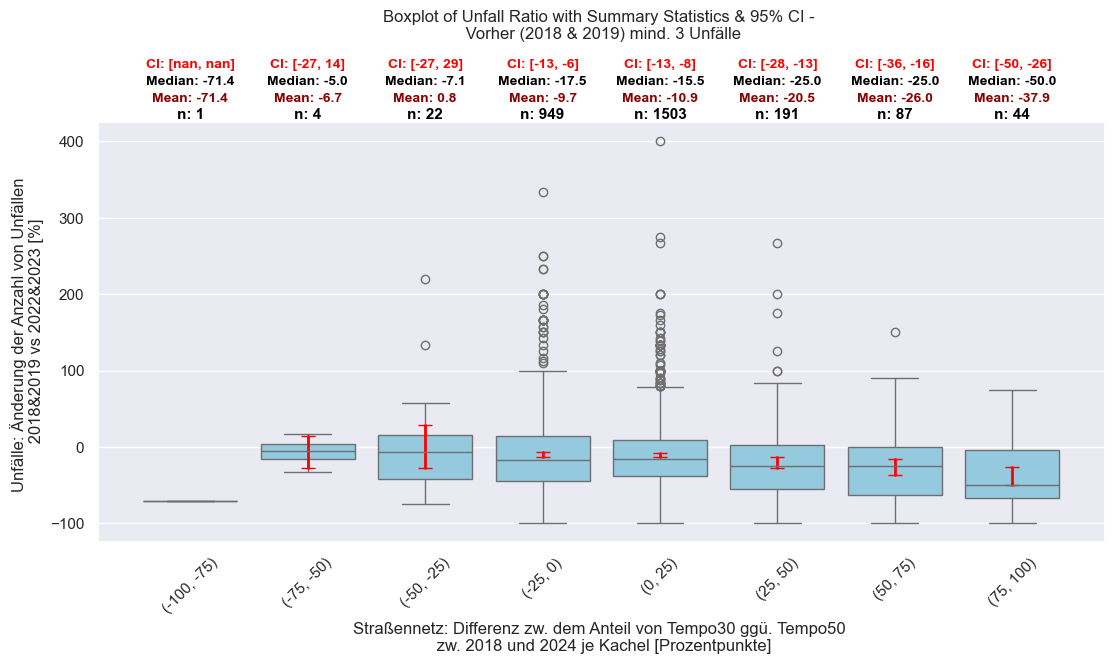

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.ticker as mticker

sns.set_theme()


#df = fin_join
#df=df[df.vorher>=3].copy()
#df=df[df.unfall_ratio<8]
#df=df[df[f"{last_year}_total_length"]>300].copy()

bins = [-100.0, -75.0, -50.0, -25.0, 0, 25.0, 50.0, 75.0, 100.0]
labels = [
    "(-100, -75)", 
    "(-75, -50)", 
    "(-50, -25)", 
    "(-25, 0)", 
    "(0, 25)", 
    "(25, 50)", 
    "(50, 75)", 
    "(75, 100)"
]

# Create a new column categorizing the data into bins
#df["group"] = pd.cut(df["diff_ratio_tempo30"], bins=bins, labels=labels, include_lowest=True)
df.loc[:, "group"] = pd.cut(df["diff_ratio_tempo30"], bins=bins, labels=labels, include_lowest=True)

# Calculate summary statistics
#summary = df.groupby("group")["unfall_ratio"].agg(["count", "mean", "median", "std"]).reset_index()
summary = df.groupby("group", observed=False)["unfall_ratio"].agg(["count", "mean", "median","std"]).reset_index()

# Compute 95% Confidence Interval (assuming values already multiplied by 100)
summary["ci_lower"] = summary["mean"] - 1.96 * (summary["std"] / np.sqrt(summary["count"]))
summary["ci_upper"] = summary["mean"] + 1.96 * (summary["std"] / np.sqrt(summary["count"]))



# **Create the boxplot**
#fig, ax = plt.subplots(figsize=(10, 7))
fig, ax = plt.subplots(figsize=(13, 7))

#sns.boxplot(x="group", y="unfall_ratio", data=df, hue="group", palette="viridis", ax=ax)
sns.boxplot(x="group", y="unfall_ratio", data=df, color="skyblue", ax=ax)

# **Custom Axis Titles**
plt.xlabel("Straßennetz: Differenz zw. dem Anteil von Tempo30 ggü. Tempo50 \n zw. 2018 und 2024 je Kachel [Prozentpunkte]")  # Change X-axis title
plt.ylabel("Unfälle: Änderung der Anzahl von Unfällen \n 2018&2019 vs 2022&2023 [%]")  # Change Y-axis title


# **Move title higher**
plt.title("Boxplot of Unfall Ratio with Summary Statistics & 95% CI - \n Vorher (2018 & 2019) mind. 3 Unfälle", pad=60)

# **Set fixed Y-position for summary stats (closer to chart)**
y_position = ax.get_ylim()[1] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.01  # Closer to plot

# **Spacing factor for better line separation**
line_spacing = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.04  # Adjust spacing between lines

# **Add Summary Statistics in multi-line format**
for i, row in summary.iterrows():
    x_pos = i  # X-axis position aligned with boxplot
    
    # Add count, mean, and median (each on a new line with improved spacing)
    ax.text(x_pos, y_position, f"n: {int(row['count'])}", ha='center', fontsize=11, fontweight="bold", color="black")
    ax.text(x_pos, y_position + line_spacing, f"Mean: {row['mean']:.1f}", ha='center', fontsize=10, fontweight="bold", color="darkred")
    ax.text(x_pos, y_position + line_spacing * 2, f"Median: {row['median']:.1f}", ha='center', fontsize=10, fontweight="bold", color="black")
       
    # **Add CI below "n"**
    ci_text = f"CI: [{row['ci_lower']:.0f}, {row['ci_upper']:.0f}]"
    ax.text(x_pos, y_position + line_spacing * 3, ci_text, 
            ha='center', fontsize=10, fontweight="bold", color="red")

    # **Plot Confidence Interval (CI) as error bars**
    ax.plot([x_pos, x_pos], [row["ci_lower"], row["ci_upper"]], color="red", linewidth=2, marker="_", markersize=10)

# Adjust plot layout
plt.subplots_adjust(top=0.80, bottom=0.2)  # Moves title up, allows space below
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

In [ ]:
# Compute 95% Confidence Interval (assuming values already multiplied by 100)
summary["ci_lower"] = summary["mean"] - 1.96 * (summary["std"] / np.sqrt(summary["count"]))
summary["ci_upper"] = summary["mean"] + 1.96 * (summary["std"] / np.sqrt(summary["count"]))


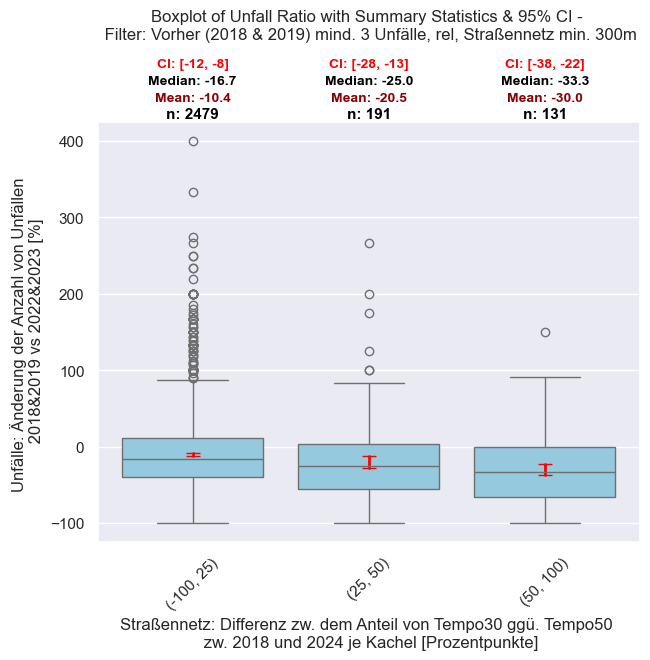

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.ticker as mticker

sns.set_theme()


#df = fin_join
#df=df[df.vorher>=3].copy()
#df=df[df.unfall_ratio<8]
#df=df[df[f"{last_year}_total_length"]>=300].copy()

bins = [-100, 25, 50, 100]
labels = [
    "(-100, 25)", 
    "(25, 50)", 
    "(50, 100)"
]

# Create a new column categorizing the data into bins
#df["group"] = pd.cut(df["diff_ratio_tempo30"], bins=bins, labels=labels, include_lowest=True)
df.loc[:, "group"] = pd.cut(df["diff_ratio_tempo30"], bins=bins, labels=labels, include_lowest=True)

# Calculate summary statistics
#summary = df.groupby("group")["unfall_ratio"].agg(["count", "mean", "median", "std"]).reset_index()
summary = df.groupby("group", observed=False)["unfall_ratio"].agg(["count", "mean", "median","std"]).reset_index()

# **Compute 95% Confidence Interval**
summary["ci_lower"] = summary["mean"] - 1.96 * (summary["std"] / np.sqrt(summary["count"]))
summary["ci_upper"] = summary["mean"] + 1.96 * (summary["std"] / np.sqrt(summary["count"]))


# **Create the boxplot**
fig, ax = plt.subplots(figsize=(7, 7))
#fig, ax = plt.subplots(figsize=(13, 7))

#sns.boxplot(x="group", y="unfall_ratio", data=df, hue="group", palette="viridis", ax=ax)
sns.boxplot(x="group", y="unfall_ratio", data=df, color="skyblue", ax=ax)

# **Custom Axis Titles**
plt.xlabel("Straßennetz: Differenz zw. dem Anteil von Tempo30 ggü. Tempo50 \n zw. 2018 und 2024 je Kachel [Prozentpunkte]")  # Change X-axis title
plt.ylabel("Unfälle: Änderung der Anzahl von Unfällen \n 2018&2019 vs 2022&2023 [%]")  # Change Y-axis title


# **Move title higher**
plt.title("Boxplot of Unfall Ratio with Summary Statistics & 95% CI - \n Filter: Vorher (2018 & 2019) mind. 3 Unfälle, rel, Straßennetz min. 300m", pad=60)

# **Set fixed Y-position for summary stats (closer to chart)**
y_position = ax.get_ylim()[1] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.01  # Closer to plot

# **Spacing factor for better line separation**
line_spacing = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.04  # Adjust spacing between lines

# **Add Summary Statistics in multi-line format**
for i, row in summary.iterrows():
    x_pos = i  # X-axis position aligned with boxplot
    
    # Add count, mean, and median (each on a new line with improved spacing)
    ax.text(x_pos, y_position, f"n: {int(row['count'])}", ha='center', fontsize=11, fontweight="bold", color="black")
    ax.text(x_pos, y_position + line_spacing, f"Mean: {row['mean']:.1f}", ha='center', fontsize=10, fontweight="bold", color="darkred")
    ax.text(x_pos, y_position + line_spacing * 2, f"Median: {row['median']:.1f}", ha='center', fontsize=10, fontweight="bold", color="black")
       
    # **Add CI below "n"**
    ci_text = f"CI: [{row['ci_lower']:.0f}, {row['ci_upper']:.0f}]"
    ax.text(x_pos, y_position + line_spacing * 3, ci_text, 
            ha='center', fontsize=10, fontweight="bold", color="red")

    # **Plot Confidence Interval (CI) as error bars**
    ax.plot([x_pos, x_pos], [row["ci_lower"], row["ci_upper"]], color="red", linewidth=2, marker="_", markersize=10)

# Adjust plot layout
plt.subplots_adjust(top=0.80, bottom=0.2)  # Moves title up, allows space below
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

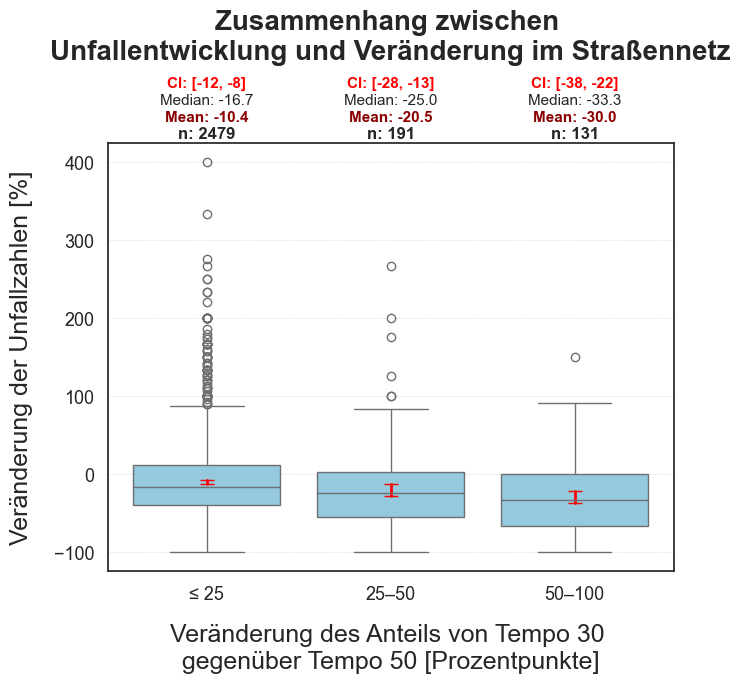

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style='white')

# Bins & Labels (already multiplied by 100)
bins = [-100, 25, 50, 100]
labels = ["≤ 25", "25–50", "50–100"]

# Create binning column
df.loc[:, "group"] = pd.cut(df["diff_ratio_tempo30"], bins=bins, labels=labels, include_lowest=True)

# Summary stats
summary = df.groupby("group", observed=False)["unfall_ratio"].agg(["count", "mean", "median", "std"]).reset_index()
summary["ci_lower"] = summary["mean"] - 1.96 * (summary["std"] / np.sqrt(summary["count"]))
summary["ci_upper"] = summary["mean"] + 1.96 * (summary["std"] / np.sqrt(summary["count"]))

# Create wider figure
fig, ax = plt.subplots(figsize=(7, 7))

# Boxplot with single color
sns.boxplot(x="group", y="unfall_ratio", data=df, color="skyblue", ax=ax)

# Title & labels
#plt.xlabel("Veränderung des Anteils von Tempo 30 gegenüber Tempo 50\nzwischen 2018 und 2024 [Prozentpunkte]", fontsize=16, labelpad=15)
#plt.ylabel("Veränderung der Unfallzahlen [%]", fontsize=16, labelpad=15)
#plt.title("Verteilung der Unfallveränderung nach Veränderung im Tempo-30-Anteil", fontsize=18, weight='bold', pad=60)

# Labels with increased font size
plt.xlabel(
    #"Veränderung des Anteils von Tempo 30 gegenüber Tempo 50\n(zwischen 2018 und 2024) [Prozentpunkte]",
    "Veränderung des Anteils von Tempo 30 \ngegenüber Tempo 50 [Prozentpunkte]",
    fontsize=18,
    labelpad=15
)
plt.ylabel(
    #"Veränderung der Unfallzahlen\n(2018/2019 vs. 2022/2023) [%]",
    "Veränderung der Unfallzahlen [%]",
    fontsize=18,
    labelpad=15
)

# Title
plt.title(
    "Zusammenhang zwischen \nUnfallentwicklung und Veränderung im Straßennetz",
    fontsize=20,
    weight='bold',
    pad=60
)

# Ticks
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Annotate summary stats
y_position = ax.get_ylim()[1] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.01
line_spacing = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.04

for i, row in summary.iterrows():
    x_pos = i
    ax.text(x_pos, y_position, f"n: {int(row['count'])}", ha='center', fontsize=12, fontweight="bold")
    ax.text(x_pos, y_position + line_spacing, f"Mean: {row['mean']:.1f}", ha='center', fontsize=11, fontweight="bold", color="darkred")
    ax.text(x_pos, y_position + line_spacing * 2, f"Median: {row['median']:.1f}", ha='center', fontsize=11)
    ax.text(x_pos, y_position + line_spacing * 3, f"CI: [{row['ci_lower']:.0f}, {row['ci_upper']:.0f}]", ha='center', fontsize=11, fontweight="bold", color="red")
    ax.plot([x_pos, x_pos], [row["ci_lower"], row["ci_upper"]], color="red", linewidth=2, marker="_", markersize=10)

# Layout & grid
plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.6)
plt.subplots_adjust(top=0.85, bottom=0.25)
plt.tight_layout()

# Save plot as high-resolution PNG before showing it
plt.savefig("../plots/boxplot_tempo30_unfallanalyse.png", dpi=400, bbox_inches='tight')

# Then show the plot
plt.show()
